## Latent diffusion with DDIM 

This example encodes spectrograms using the scheduler. We can then interpolate between encoded spectrograms and decode them through the unet to audio. In the unet bends can be applied (see bending notebook)

In [1]:
import torch
from IPython.display import Audio
import random
import numpy as np
from datasets import load_dataset
from diffusers import DiffusionPipeline, DDIMScheduler, AutoencoderKL, AudioDiffusionPipeline
from diffusers_local import UNet2DModel as UNet2DModel_local

device = "cuda" if torch.cuda.is_available() else "cpu"
audio_diffusion = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-ddim-256")
# apply the custom unet model so we can Networkbend the audio
audio_diffusion.unet = UNet2DModel_local.from_pretrained("teticio/audio-diffusion-ddim-256", subfolder="unet")
#set the scheduler to DDIM
audio_diffusion.scheduler = DDIMScheduler.from_pretrained("teticio/audio-diffusion-ddim-256", subfolder="scheduler")
#set the vqvae
#audio_diffusion.vqvae = AutoencoderKL.from_pretrained("teticio/audio-diffusion-ddim-256", subfolder="vqvae")
#load the model to the GPU/CPU
audio_diffusion.to(device)

print(audio_diffusion)

ds = load_dataset('teticio/audio-diffusion-256')
generator=torch.Generator(device="cpu").manual_seed(42)


A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
unet\diffusion_pytorch_model.safetensors not found


ImportError: 
AudioDiffusionPipeline requires the librosa library but it was not found in your environment.  Checkout the instructions on the
installation page: https://librosa.org/doc/latest/install.html and follow the ones that match your environment.


In [2]:
from librosa.beat import beat_track

def loop_it(audio: np.ndarray,
        sample_rate: int,
        loops: int = 4) -> np.ndarray:
    """Loop audio

    Args:
        audio (np.ndarray): audio as numpy array
        sample_rate (int): sample rate of audio
        loops (int): number of times to loop

    Returns:
        (float, np.ndarray): sample rate and raw audio or None
    """
    _, beats = beat_track(y=audio, sr=sample_rate, units='samples')
    for beats_in_bar in [16, 12, 8, 4]:
        if len(beats) > beats_in_bar:
            return np.tile(audio[beats[0]:beats[beats_in_bar]], loops)
    return None

In [3]:
#load 20 images from the dataset
images = []

for i in range(50):
    images.append(random.choice(ds['train'])['image'])

images

[<PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>,
 <PIL.Pn

In [4]:
#encode images in latent space
encoded_images = []

for i in range(50):
    noise = audio_diffusion.encode([images[i]])
    encoded_images.append(noise)
    

  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\danhearn\Documents\GitHub\diffusertrack\diffusers_local\models\attention_processor.py:2367: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 50/50 [00:01<00:00, 40.51it/s]


100%|██████████| 50/50 [00:01<00:00, 30.88it/s]


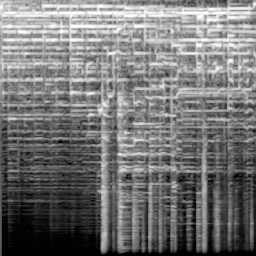

In [8]:
alpha = 0.5  #@param {type:"slider", min:0, max:1, step:0.1}
output = audio_diffusion(steps=50,
    noise=AudioDiffusionPipeline.slerp(encoded_images[0], encoded_images[2], alpha),
    generator=generator, eta=0)
image = output.images[0]
audio = output.audios[0, 0]
display(image)
display(Audio(audio, rate=audio_diffusion.mel.get_sample_rate()))
loop = loop_it(audio, audio_diffusion.mel.get_sample_rate())
if loop is not None:
    display(Audio(loop, rate=audio_diffusion.mel.get_sample_rate()))
else:
    print("Unable to determine loop points")